<a href="https://colab.research.google.com/github/tariqshaban/suicide-detection/blob/master/Suicide%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
# Display generic output messages
!pip install colorama

# Huggingface related libraries
!pip install transformers datasets evaluate

# Download assets from the GitHub repository
!apt install subversion
!svn checkout https://github.com/tariqshaban/suicide-detection/trunk/assets

import itertools
import json
import evaluate
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sklearn.metrics as metrics
import urllib
import tensorflow as tf

from colorama import Fore, Back, Style

from datasets import Dataset
from datasets import DatasetDict
from datasets import load_dataset

from IPython.display import Image, display, clear_output

from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import History, EarlyStopping

from transformers import AutoTokenizer
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from transformers import pipeline
from transformers import TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback

from tqdm.auto import tqdm

from typing import Dict

from wordcloud import WordCloud

# Download required NLTK dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Allow to display TQDM for complex Pandas lambda expressions
tqdm.pandas()


# Acquire the dataset from its LFS source

# Obtain LFS file metadata
with open('assets/dataset/Suicide_Detection.csv') as file:
    lines = [line.rstrip() for line in file]
sha = lines[1][lines[1].index(':')+1:]
size = lines[2][lines[2].index(' ')+1:]

# Acquire direct download link
payload =  f'''
{{
    "operation": "download", 
    "transfer": ["basic"], 
    "objects": [
        {{"oid": "{sha}", "size": {size}}}
    ]
}}
'''
curl = f'''
curl -X POST \
-H 'Accept: application/vnd.git-lfs+json' \
-H 'Content-type: application/json' \
-d '{payload}' \
https://github.com/tariqshaban/suicide-detection.git/info/lfs/objects/batch
'''
response = json.loads(os.popen(curl).read())
file_url = response['objects'][0]['actions']['download']['href']

# Replace LFS metadata with the actual file
!rm assets/dataset/Suicide_Detection.csv
urllib.request.urlretrieve(file_url, 'assets/dataset/Suicide_Detection.csv')


clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



# Defining Constants

In [2]:
DATASET_FILENAME = './assets/dataset/Suicide_Detection.csv'
PLOTS_OUTPUT = './assets/output/images'
MODEL_OUTPUT = './assets/output/model'

ID2LABEL = {0: 'non-suicide', 1: 'suicide'}
LABEL2ID = {'non-suicide': 0, 'suicide': 1}

LABELS = list(LABEL2ID.keys())

SAMPLE_FRACTION = 1

VALIDATION_SIZE = 0.01
TEST_SIZE = 0.005

BATCH_SIZE = 2
EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30
EARLY_STOPPING_MIN_DELTA = 0.001

# Helper Methods

### EDA

In [3]:
def perform_eda():
    """
    Perform preliminary exploratory data analysis on the saved dataset.

    :return: The tokenizer
    """

    def show_label_distribution(
            dataset: pd.DataFrame,
            title: str = None,
    ):
        """
        Plots the label distribution.

        :param pd.DataFrame dataset: The dataset to plot from
        :param str title: The title displayed on the generated plot
        """

        label_distribution = dataset['class'].value_counts()

        labels = list(label_distribution.keys())
        values = list(label_distribution.values)
        colors = ['red', 'green']

        plt.bar(labels, values, color=colors)

        plt.xlabel('Class')
        plt.ylabel('Occurrences')
        plt.title(title)
        plt.show()

    def show_word_length_distribution(
            dataset: pd.DataFrame,
            title: str = None,
    ):
        """
        Plots the word length distribution.

        :param pd.DataFrame dataset: The dataset to plot from
        :param str title: The title displayed on the generated plot
        """

        words_count = dataset['text'].progress_apply(lambda text: len(re.sub(' {2,}', ' ', text).split(' '))).values

        d = np.abs(words_count - np.median(words_count))
        mdev = np.median(d)
        s = d / mdev if mdev else np.zeros(len(d))

        # The value of 3.5 denotes that we wish to discard 0.05% of the data (which represent the outlier)
        words_count = words_count[s < 3.5]

        plt.hist(words_count, bins=30)

        plt.xlabel('Words Length')
        plt.ylabel('Occurrences')
        plt.title(title)
        plt.show()

    def show_character_length_distribution(
            dataset: pd.DataFrame,
            title: str = None,
    ):
        """
        Plots the character length distribution.

        :param pd.DataFrame dataset: The dataset to plot from
        :param str title: The title displayed on the generated plot
        """

        characters_count = dataset['text'].progress_apply(lambda text: len(text) - text.count(' ')).values

        d = np.abs(characters_count - np.median(characters_count))
        mdev = np.median(d)
        s = d / mdev if mdev else np.zeros(len(d))

        # The value of 3.5 denotes that we wish to discard 0.05% of the data (which represent the outlier)
        characters_count = characters_count[s < 3.5]

        plt.hist(characters_count, bins=30)

        plt.xlabel('Characters Length')
        plt.ylabel('Occurrences')
        plt.title(title)
        plt.show()

    def show_character_word_length_distribution(
            dataset: pd.DataFrame,
            title: str = None,
    ):
        """
        Plots the character/word length distribution.

        :param pd.DataFrame dataset: The dataset to plot from
        :param str title: The title displayed on the generated plot
        """

        characters_words_ratio = dataset['text'].progress_apply(
            lambda text: (len(text) - text.count(' ')) / len(text.split(' '))).values

        d = np.abs(characters_words_ratio - np.median(characters_words_ratio))
        mdev = np.median(d)
        s = d / mdev if mdev else np.zeros(len(d))

        # The value of 3.5 denotes that we wish to discard 0.05% of the data (which represent the outlier)
        characters_words_ratio = characters_words_ratio[s < 3.5]

        plt.hist(characters_words_ratio, bins=30)

        plt.xlabel('Characters/Words Ratio')
        plt.ylabel('Occurrences')
        plt.title(title)
        plt.show()

    def apply_nlp_preprocessing(
            dataset: pd.DataFrame,
    ) -> [DatasetDict, pd.DataFrame]:
        """
        Apply basic nlp operations.

        :param pd.DataFrame dataset: The dataset to preprocess
        :return: The preprocessed dataset
        """

        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        sentiment = SentimentIntensityAnalyzer()

        dataset['text_tokenized'] = dataset['text'].progress_apply(
            lambda text: word_tokenize(re.sub(r'[^A-Za-z0-9 ]+', '', text)))

        def get_lemmatized_word(word):
            pos = pos_tag([word])[0][-1][0].lower()
            pos = pos if pos in ['a', 'r', 'n', 'v'] else None
            if not pos:
                return word
            else:
                return lemmatizer.lemmatize(word, pos)

        dataset['text_tokenized'] = dataset['text_tokenized'].progress_apply(
            lambda text: [word.lower() for word in text])
        dataset['text_tokenized'] = dataset['text_tokenized'].progress_apply(
            lambda text: [word for word in text if word not in stop_words])
        dataset['text_tokenized'] = dataset['text_tokenized'].progress_apply(
            lambda text: [get_lemmatized_word(word) for word in text])
        dataset['text_tokenized'] = dataset['text_tokenized'].progress_apply(
            lambda text: [word for word in text if not word.isdigit()])

        dataset['sentiment'] = dataset['text'].progress_apply(lambda text: sentiment.polarity_scores(text)['compound'])

        return dataset

    def plot_sentiment_distribution(
            dataset: pd.DataFrame,
            title: str = None,
    ):
        """
        Plots the sentiment distribution.

        :param pd.DataFrame dataset: The words to plot from
        :param str title: The title displayed on the generated plot
        """

        labels = list(dataset['sentiment'].value_counts().keys())
        values = list(dataset['sentiment'].value_counts().values)

        n, bins, patches = plt.hist(labels, weights=values, bins=30, orientation='horizontal')

        color_map = plt.cm.get_cmap('RdYlBu')
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        col = bin_centers - min(bin_centers)
        col /= max(col)
        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', color_map(c))

        plt.xlabel('Occurrences')
        plt.ylabel('Sentiment Value')
        plt.title(title)
        plt.show()

    def plot_most_common_words(
            words: np.ndarray,
            n: int = 30,
            title: str = None,
    ):
        """
        Plots the most common n words.

        :param np.array words: The words to plot from
        :param int n: Number of common words to plot
        :param str title: The title displayed on the generated plot
        """

        most_common = dict(nltk.FreqDist(words).most_common(n))

        labels = list(most_common.keys())
        values = list(most_common.values())

        plt.bar(labels, values)
        plt.xlabel(f'Most Common {n} Words')
        plt.ylabel('Occurrences')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()

    def plot_most_common_bigrams(
            words: np.ndarray,
            n: int = 30,
            title: str = None,
    ):
        """
        Plots the most common n bigrams.

        :param np.array words: The words to plot from
        :param int n: Number of common bigrams to plot
        :param str title: The title displayed on the generated plot
        """

        most_common_bigram = dict(nltk.FreqDist(nltk.bigrams(words)).most_common(n ** 2))

        most_common_bigram = {key: val for key, val in most_common_bigram.items() if len(set(key)) == len(key)}

        most_common_bigram = dict(itertools.islice(most_common_bigram.items(), n))

        labels = list(most_common_bigram.keys())
        labels = [f'{label[0]} - {label[1]}' for label in labels]
        values = list(most_common_bigram.values())

        plt.bar(labels, values)
        plt.xlabel(f'Most Common {n} Bigram Words')
        plt.ylabel('Occurrences')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()

    def plot_most_common_trigrams(
            words: np.ndarray,
            n: int = 30,
            title: str = None,
    ):
        """
        Plots the most common n trigrams.

        :param np.array words: The words to plot from
        :param int n: Number of common trigrams to plot
        :param str title: The title displayed on the generated plot
        """

        most_common_trigram = dict(nltk.FreqDist(nltk.trigrams(words)).most_common(n ** 2))

        most_common_trigram = {key: val for key, val in most_common_trigram.items() if len(set(key)) == len(key)}

        most_common_trigram = dict(itertools.islice(most_common_trigram.items(), n))

        labels = list(most_common_trigram.keys())
        labels = [f'{label[0]} - {label[1]} - {label[2]}' for label in labels]
        values = list(most_common_trigram.values())

        plt.bar(labels, values)
        plt.xlabel(f'Most Common {n} Trigram Words')
        plt.ylabel('Occurrences')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()

    def plot_word_cloud(
            words: np.ndarray,
    ):
        """
        Plots a word cloud.

        :param np.array words: The words to plot from
        """

        wordcloud = WordCloud(width=1920, height=1080, collocations=False).generate(' '.join(words))

        plt.figure(figsize=(16, 9))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()

    df = pd.read_csv(DATASET_FILENAME).sample(frac=SAMPLE_FRACTION)
    df_positive = df[df['class'] == 'suicide'].copy()
    df_negative = df[df['class'] == 'non-suicide'].copy()

    display(df)
    display(df_positive)
    display(df_negative)

    show_label_distribution(df, title='Label Distribution')

    show_word_length_distribution(df, title='Word Length Distribution')
    show_word_length_distribution(df_positive, title='Word Length Distribution for Positive Examples')
    show_word_length_distribution(df_negative, title='Word Length Distribution for Negative Examples')

    show_character_length_distribution(df, title='Character Length Distribution')
    show_character_length_distribution(df_positive, title='Character Length Distribution for Positive Examples')
    show_character_length_distribution(df_negative, title='Character Length Distribution for Negative Examples')

    show_character_word_length_distribution(df, title='Character/Word Length Distribution')
    show_character_word_length_distribution(df_positive, title='Character/Word Length Distribution for Positive Examples')
    show_character_word_length_distribution(df_negative, title='Character/Word Length Distribution for Negative Examples')

    df = apply_nlp_preprocessing(df)
    df_positive = apply_nlp_preprocessing(df_positive)
    df_negative = apply_nlp_preprocessing(df_negative)

    plot_sentiment_distribution(df, title='Sentiment Distribution')
    plot_sentiment_distribution(df_positive, title='Sentiment Distribution for Positive Examples')
    plot_sentiment_distribution(df_negative, title='Sentiment Distribution for Negative Examples')

    flattened_words = list(itertools.chain.from_iterable(df['text_tokenized'].values))
    flattened_words_positive = list(itertools.chain.from_iterable(df_positive['text_tokenized'].values))
    flattened_words_negative = list(itertools.chain.from_iterable(df_negative['text_tokenized'].values))

    common_positive = list(dict(nltk.FreqDist(flattened_words_positive).most_common(500)).keys())
    common_negative = list(dict(nltk.FreqDist(flattened_words_negative).most_common(500)).keys())
    common_intersection = list(set(common_positive) & set(common_negative))

    flattened_words = [word for word in flattened_words if word not in common_intersection]
    flattened_words_positive = [word for word in flattened_words_positive if word not in common_intersection]
    flattened_words_negative = [word for word in flattened_words_negative if word not in common_intersection]

    plot_most_common_words(flattened_words, title='Most Common 30 Words')
    plot_most_common_words(flattened_words_positive, title='Most Common 30 Words for Positive Examples')
    plot_most_common_words(flattened_words_negative, title='Most Common 30 Words for Negative Examples')

    plot_most_common_bigrams(flattened_words, title='Top 30 Bigrams')
    plot_most_common_bigrams(flattened_words_positive, title='Top 30 Bigrams for Positive Examples')
    plot_most_common_bigrams(flattened_words_negative, title='Top 30 Bigrams for Negative Examples')

    plot_most_common_trigrams(flattened_words, title='Top 30 Trigrams')
    plot_most_common_trigrams(flattened_words_positive, title='Top 30 Trigrams for Positive Examples')
    plot_most_common_trigrams(flattened_words_negative, title='Top 30 Trigrams for Negative Examples')

    plot_word_cloud(flattened_words)
    plot_word_cloud(flattened_words_positive)
    plot_word_cloud(flattened_words_negative)

### Get Tokenizor

In [4]:
def get_tokenizer() -> any:
    """
    Fetches the distilbert-base-uncased tokenizer.

    :return: The tokenizer
    """

    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    return tokenizer

### Get Pretrained Model

In [5]:
def get_pretrained_model() -> any:
    """
    Fetches the distilbert-base-uncased pre-trained model, based on the ID2LABEL and LABEL2ID.

    :return: The pre-trained model
    """

    model = TFAutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=2, id2label=ID2LABEL, label2id=LABEL2ID
    )

    return model

### Get Trained Model Pipeline

In [6]:
def get_trained_pipeline() -> any:
    """
    Returns a pipeline from the trained model; based on the MODEL_OUTPUT.

    :return: The trained model
    """

    trained_pipeline = pipeline('sentiment-analysis', model=MODEL_OUTPUT, tokenizer=MODEL_OUTPUT)

    return trained_pipeline

### Prime Dataset

In [7]:
def prime_dataset(
        tokenizer: any,
) -> [DatasetDict, pd.DataFrame]:
    """
    Ready the dataset for training.

    :param any tokenizer: The tokenizer object
    :return: The processed dataset
    """

    def preprocess_function(
            examples: any,
    ) -> any:
        """
        Converts the label of the dataset to a numerical ID; and tokenizes the text.

        :param any examples: The batched examples
        :return: The processed examples
        """

        examples['label'] = [LABEL2ID.get(e, e) for e in examples['label']]
        return tokenizer(examples['text'], truncation=True)

    df = pd.read_csv(DATASET_FILENAME)
    df = df.sample(frac=SAMPLE_FRACTION)

    df_train_valid = df.sample(frac=1 - TEST_SIZE)
    df_test = df.drop(df_train_valid.index)

    suicide_detection = Dataset.from_pandas(df_train_valid)

    suicide_detection = suicide_detection.rename_column('class', 'label')
    suicide_detection = suicide_detection.remove_columns('Unnamed: 0')
    suicide_detection = suicide_detection.train_test_split(test_size=VALIDATION_SIZE / (1 - TEST_SIZE))

    tokenized_suicide_detection = suicide_detection.map(preprocess_function, batched=True)

    return [tokenized_suicide_detection, df_test]

### Visualize Model Results

In [8]:
def visualize_model(
        test_dataset: pd.DataFrame,
        fitted_model: History,
):
    """
    Display plots based on the trained model.

    :param pd.DataFrame test_dataset: The dataset to test on
    :param History fitted_model: The trained model
    """

    trained_pipeline = get_trained_pipeline()

    plt.plot(fitted_model.history['loss'])
    plt.plot(fitted_model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig(f'{PLOTS_OUTPUT}/loss_history.png')
    plt.show()

    y_predict = [prediction['label'] for prediction in
                 trained_pipeline(test_dataset['text'].to_list(), truncation=True, max_length=4096)]
    y_true = test_dataset['class'].to_list()

    ax = sns.heatmap(confusion_matrix(y_true, y_predict, labels=LABELS), annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(LABELS)
    ax.yaxis.set_ticklabels(LABELS)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.savefig(f'{PLOTS_OUTPUT}/confusion_matrix.png')
    plt.show()

### Train Model

In [9]:
def train_model(
        tokenizer: any,
        tokenized_dataset: DatasetDict,
        test_dataset: pd.DataFrame,
        visualize: bool = True,
        export_model: bool = True,
):
    """
    Trains the model.

    :param any tokenizer: The embedding's tokenizer
    :param DatasetDict tokenized_dataset: The preprocessed training dataset
    :param pd.DataFrame test_dataset: The testing dataset
    :param bool visualize: Whether to show visualizations or not
    :param bool export_model: Whether to export the model or not
    """

    def compute_metrics(
        eval_pred: any,
    ) -> dict:
        """
        Computes a custom prediction for the training.

        :param any eval_pred: An object containing the prediction and actual value
        :return: The computed metric for the example
        """

        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return accuracy.compute(predictions=predictions, references=labels)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

    accuracy = evaluate.load('accuracy')

    batches_per_epoch = len(tokenized_dataset['train'])
    total_train_steps = int(batches_per_epoch * EPOCHS)
    optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

    model = get_pretrained_model()

    train_set = model.prepare_tf_dataset(
        tokenized_dataset['train'],
        shuffle=True,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )

    validation_set = model.prepare_tf_dataset(
        tokenized_dataset['test'],
        shuffle=False,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )

    model.compile(optimizer=optimizer)

    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=EARLY_STOPPING_PATIENCE, min_delta=EARLY_STOPPING_MIN_DELTA)

    metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=validation_set)

    callbacks = [es, metric_callback]

    fitted_model = model.fit(x=train_set, validation_data=validation_set, epochs=EPOCHS, callbacks=callbacks)

    loss = model.evaluate(validation_set)

    print(Fore.GREEN + u'\n\u2713 ' + f'Loss ==> {loss}')
    print(Fore.RESET)

    model.summary()

    if export_model:
        tokenizer.save_pretrained(MODEL_OUTPUT)
        model.save_pretrained(MODEL_OUTPUT)

    if visualize:
        visualize_model(test_dataset=test_dataset, fitted_model=fitted_model)

In [10]:
def evaluate_model(
        test_dataset: pd.DataFrame,
):
    """
    Evaluates the trained model based on the training dataset

    :param pd.DataFrame test_dataset: The testing dataset
    :return: A dictionary containing the evaluation metric type as the key and its value as the value
    """

    trained_pipeline = get_trained_pipeline()

    y_predict = [prediction['label'] for prediction in
                 trained_pipeline(test_dataset['text'].to_list(), truncation=True, max_length=4096)]
    y_true = test_dataset['class'].to_list()

    accuracy = metrics.accuracy_score(y_true, y_predict)
    precision = metrics.precision_score(y_true, y_predict, pos_label=LABELS[-1])
    recall = metrics.recall_score(y_true, y_predict, pos_label=LABELS[-1])
    f1_score = metrics.f1_score(y_true, y_predict, pos_label=LABELS[-1])

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
    }

# Methods Invocation

,Unnamed: 0,text,class
230603,345883,"Confused and feeling alone, just need to get t...",suicide
36598,54877,Overdose by antidepressants and sleeping pills...,suicide
89665,134689,Anyone else have a crippling fear of ceasing t...,non-suicide
205721,308625,It’s too muchIt’s been a year since I had a ar...,suicide
127585,191685,Please wake me upThis can’t be real this doesn...,suicide
...,...,...,...
128963,193682,What do i do?Can't seem to get to the place i ...,suicide
114201,171622,After almost three years and lots of procrasti...,non-suicide
228232,342270,I can't live with myself because of what I've ...,suicide
45301,67860,"Sexual abuse, bullied, anxiety, depressionyou ...",suicide


,Unnamed: 0,text,class
230603,345883,"Confused and feeling alone, just need to get t...",suicide
36598,54877,Overdose by antidepressants and sleeping pills...,suicide
205721,308625,It’s too muchIt’s been a year since I had a ar...,suicide
127585,191685,Please wake me upThis can’t be real this doesn...,suicide
124693,187378,having suicidal thoughts. what are the legal i...,suicide
...,...,...,...
111890,168124,Constantly paranoidI can't do it anymore... I ...,suicide
199022,298631,I wish I didn't have any feeling in my neckTha...,suicide
128963,193682,What do i do?Can't seem to get to the place i ...,suicide
228232,342270,I can't live with myself because of what I've ...,suicide


,Unnamed: 0,text,class
89665,134689,Anyone else have a crippling fear of ceasing t...,non-suicide
63616,95380,how do I get out of my friend group? I have a...,non-suicide
126602,190191,"Ugghhhh, I’m in one of those moods again So ir...",non-suicide
148045,222154,If you’re short... I’m jealous. Why am I so fu...,non-suicide
165721,248658,I am going to make worlds best playlist. Share...,non-suicide
...,...,...,...
199260,298999,I don't understand why redditors buy awerds Re...,non-suicide
74672,112131,I want to be a ventriloquist Just to bully bli...,non-suicide
90242,135566,AAAA I'm literally the stupidest person in exi...,non-suicide
114201,171622,After almost three years and lots of procrasti...,non-suicide


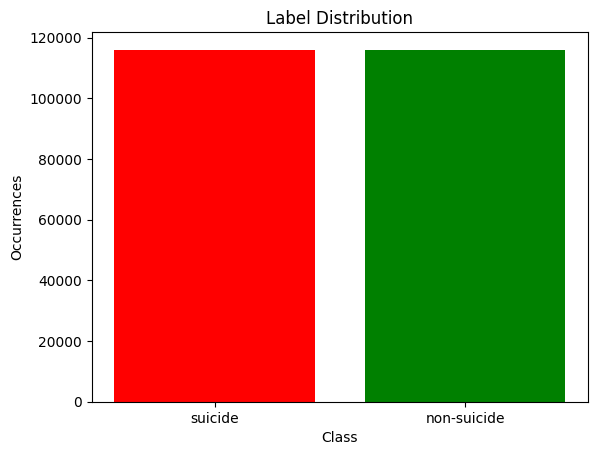

  0%|          | 0/232074 [00:00<?, ?it/s]

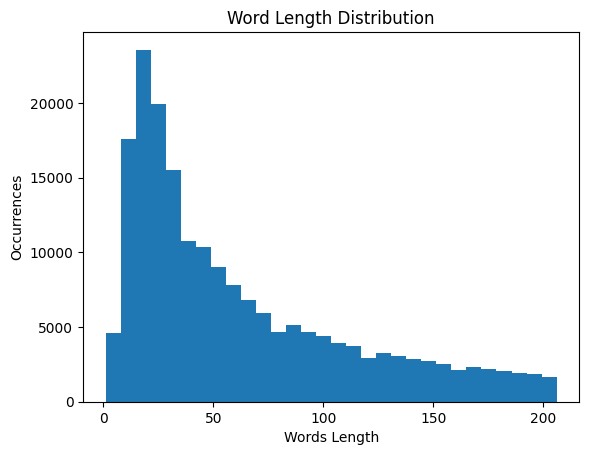

  0%|          | 0/116037 [00:00<?, ?it/s]

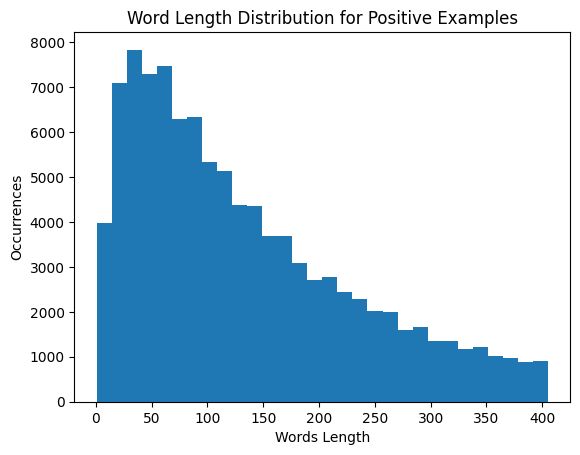

  0%|          | 0/116037 [00:00<?, ?it/s]

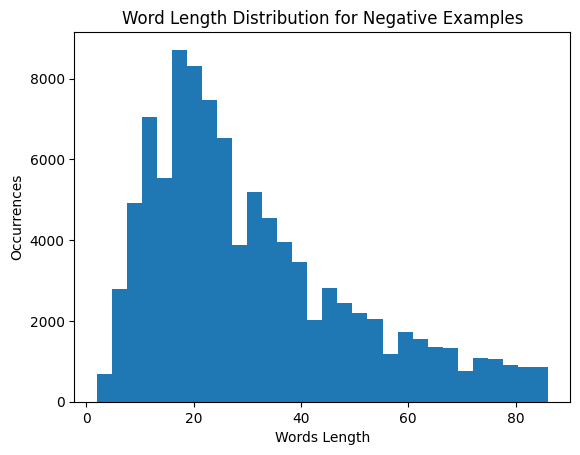

  0%|          | 0/232074 [00:00<?, ?it/s]

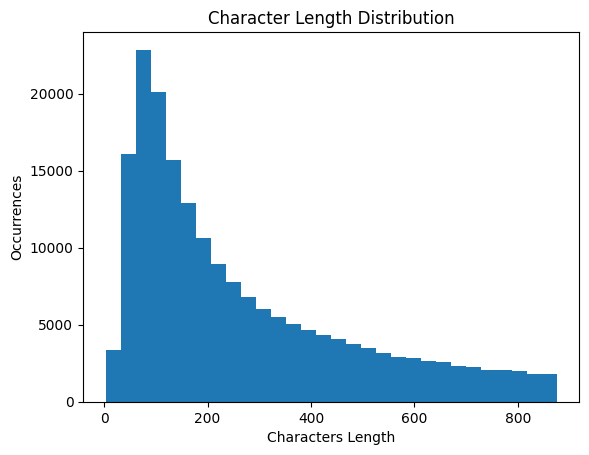

  0%|          | 0/116037 [00:00<?, ?it/s]

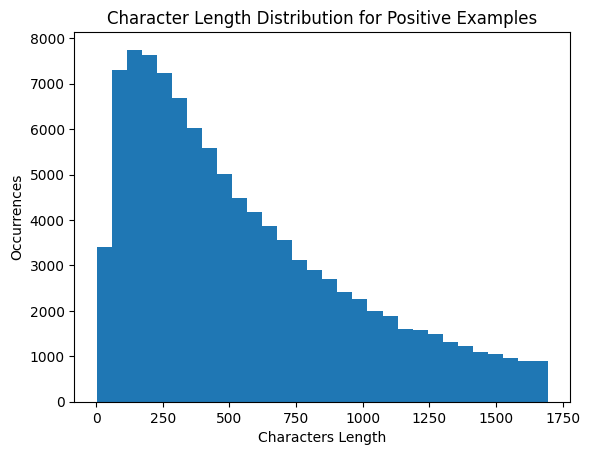

  0%|          | 0/116037 [00:00<?, ?it/s]

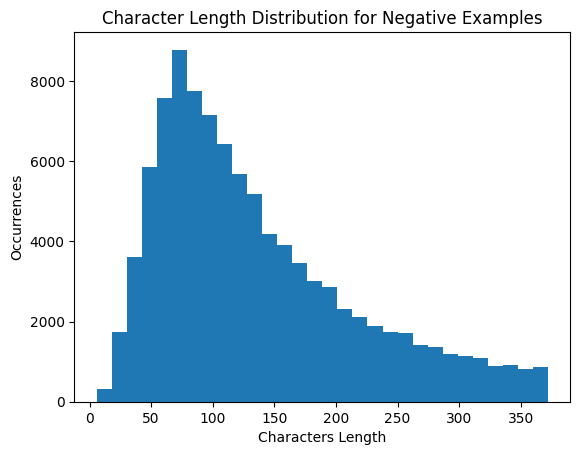

  0%|          | 0/232074 [00:00<?, ?it/s]

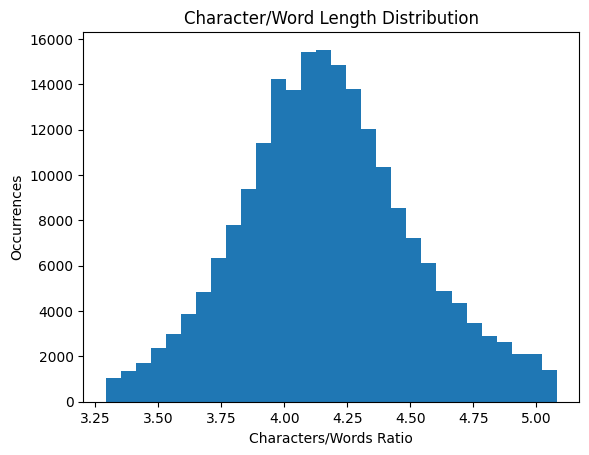

  0%|          | 0/116037 [00:00<?, ?it/s]

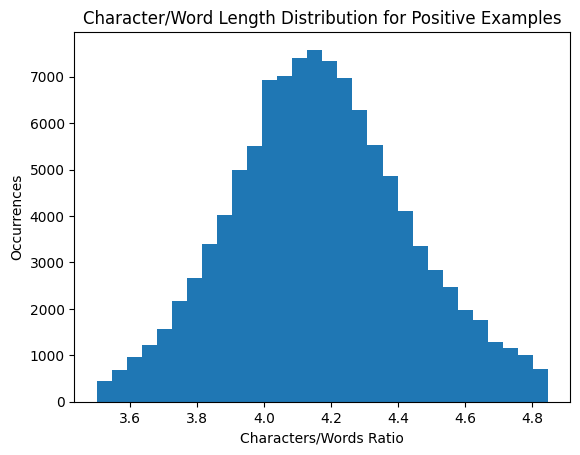

  0%|          | 0/116037 [00:00<?, ?it/s]

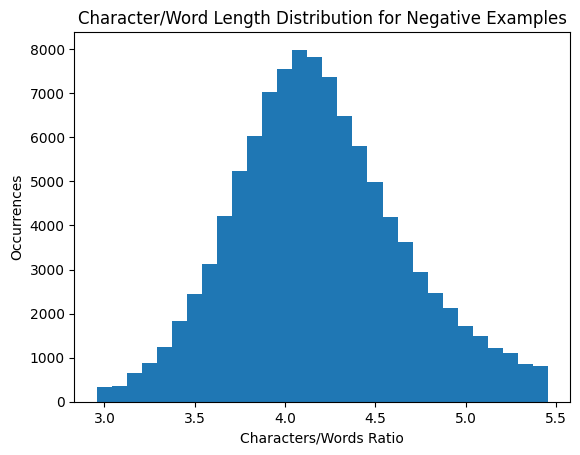

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

  0%|          | 0/116037 [00:00<?, ?it/s]

C:\Users\G.Tata\AppData\Local\Temp\ipykernel_67612\2385997117.py:168: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('RdYlBu')


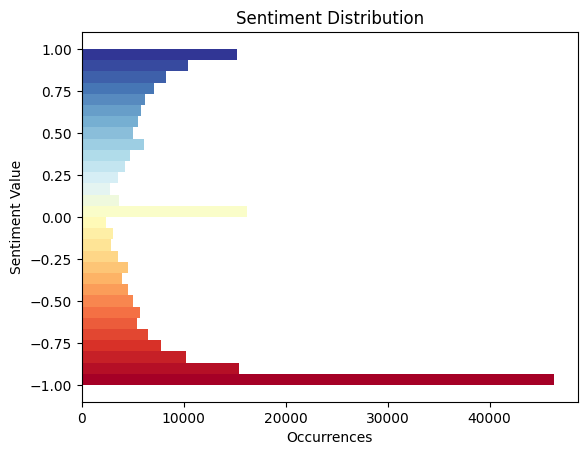

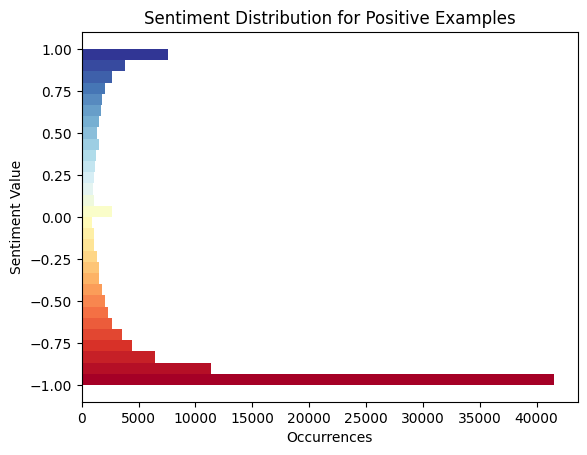

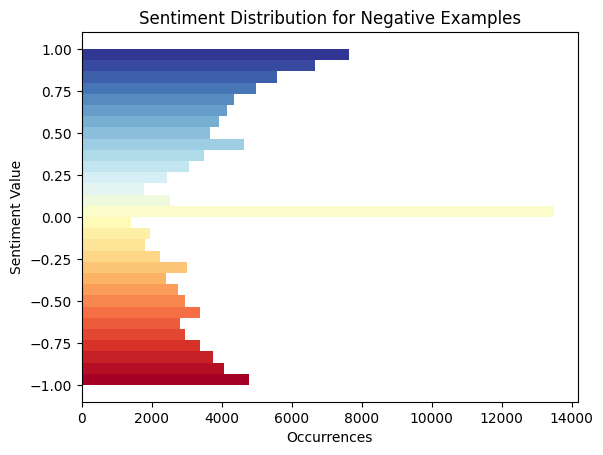

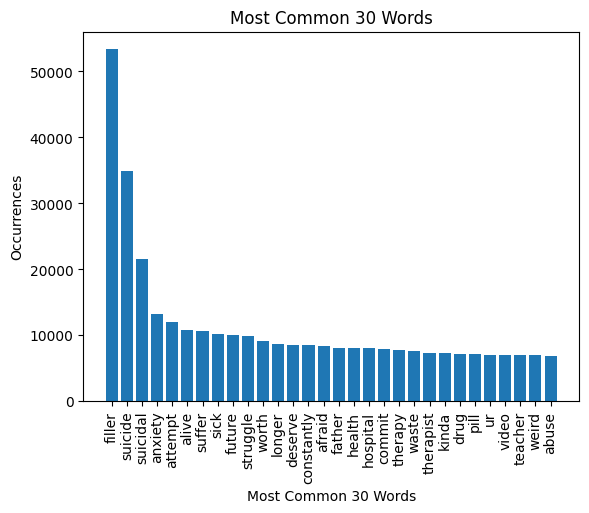

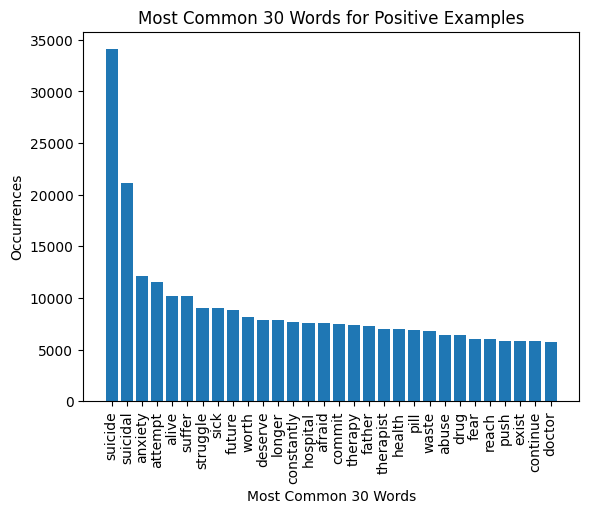

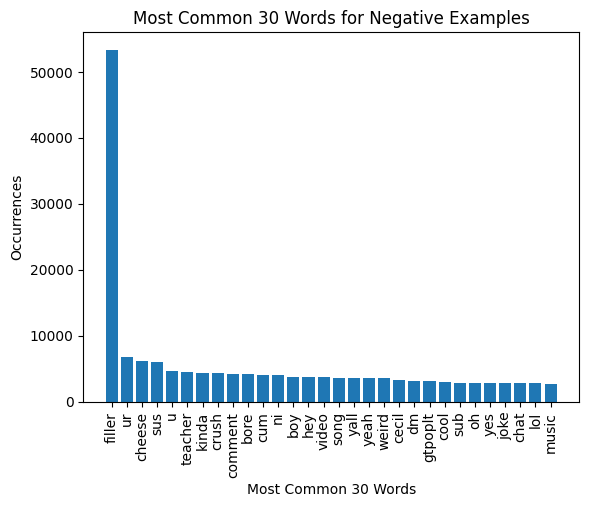

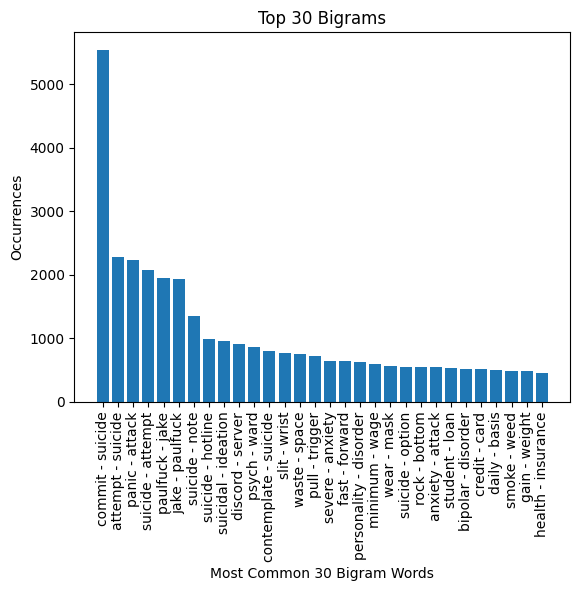

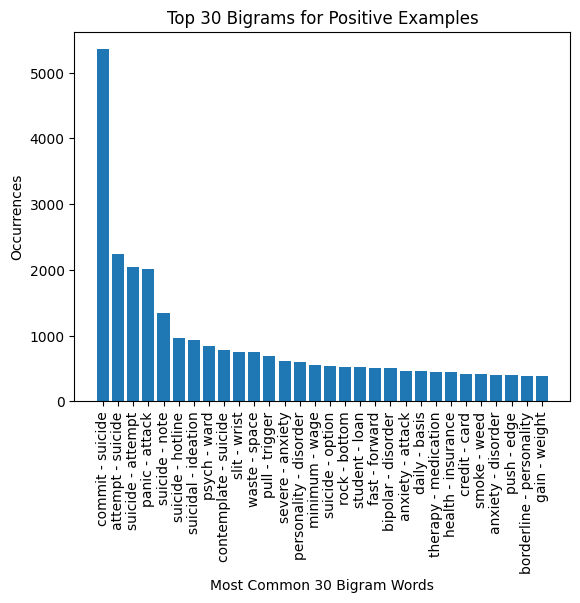

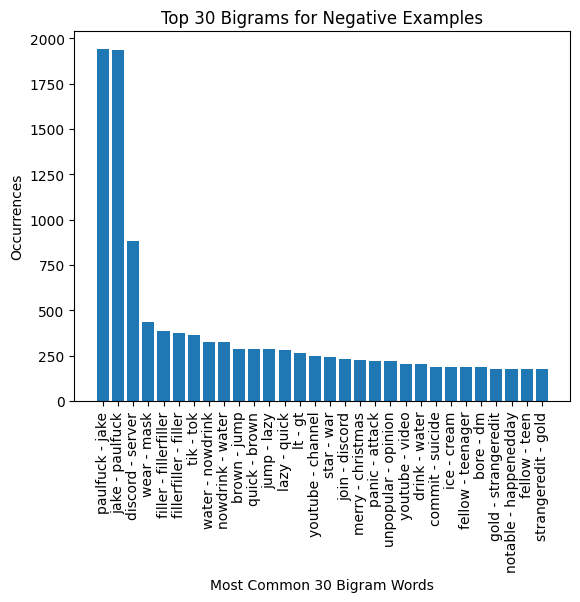

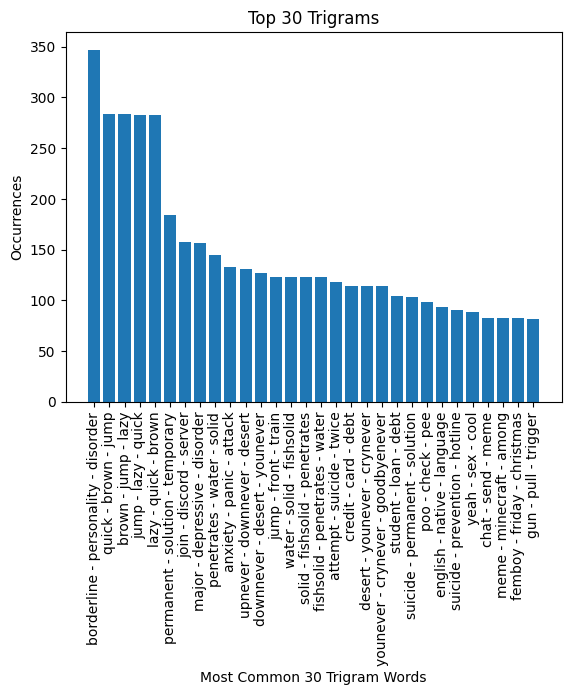

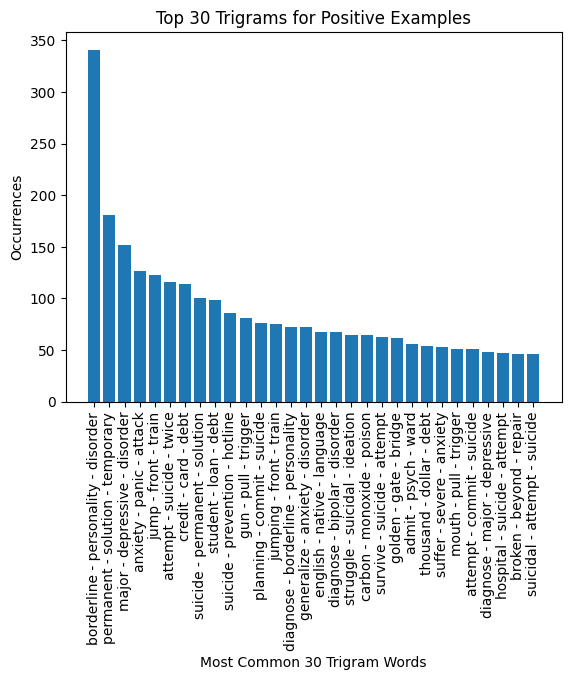

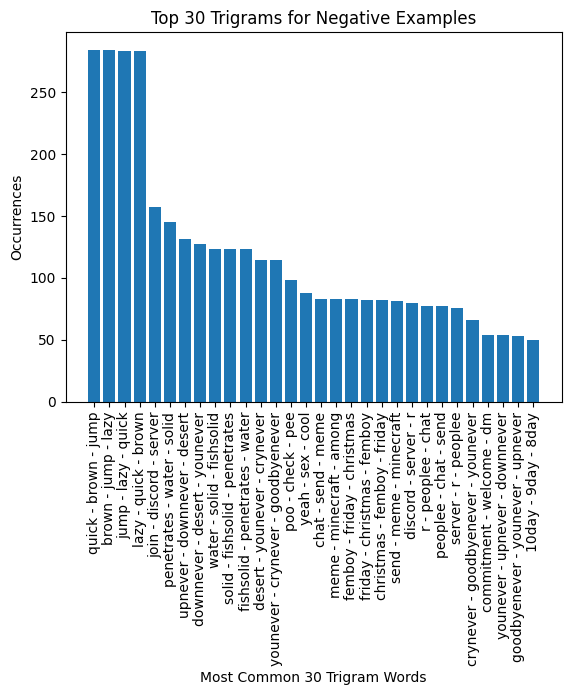

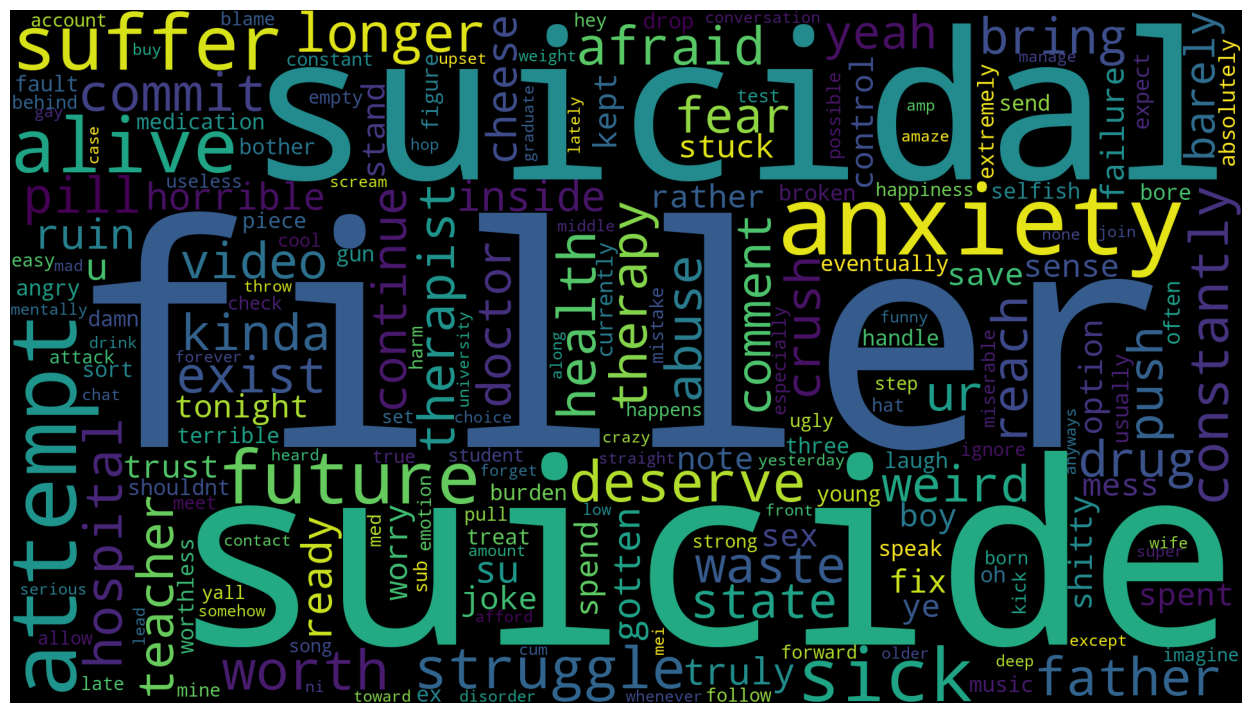

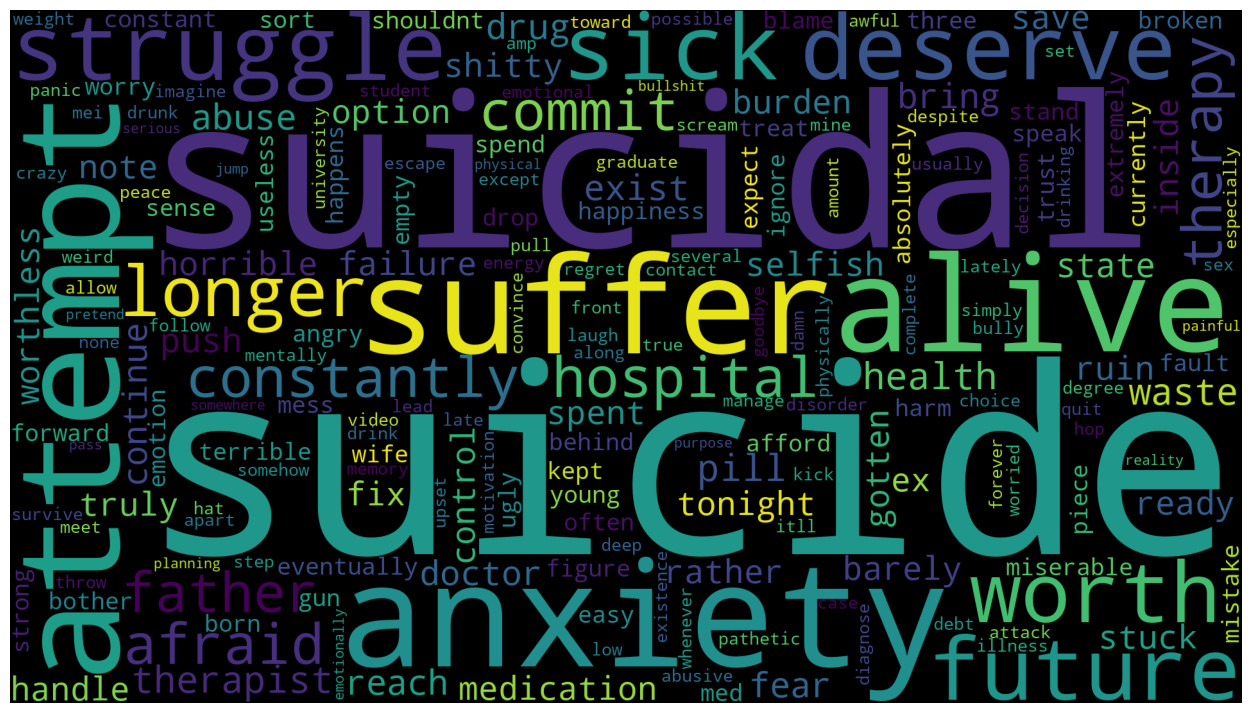

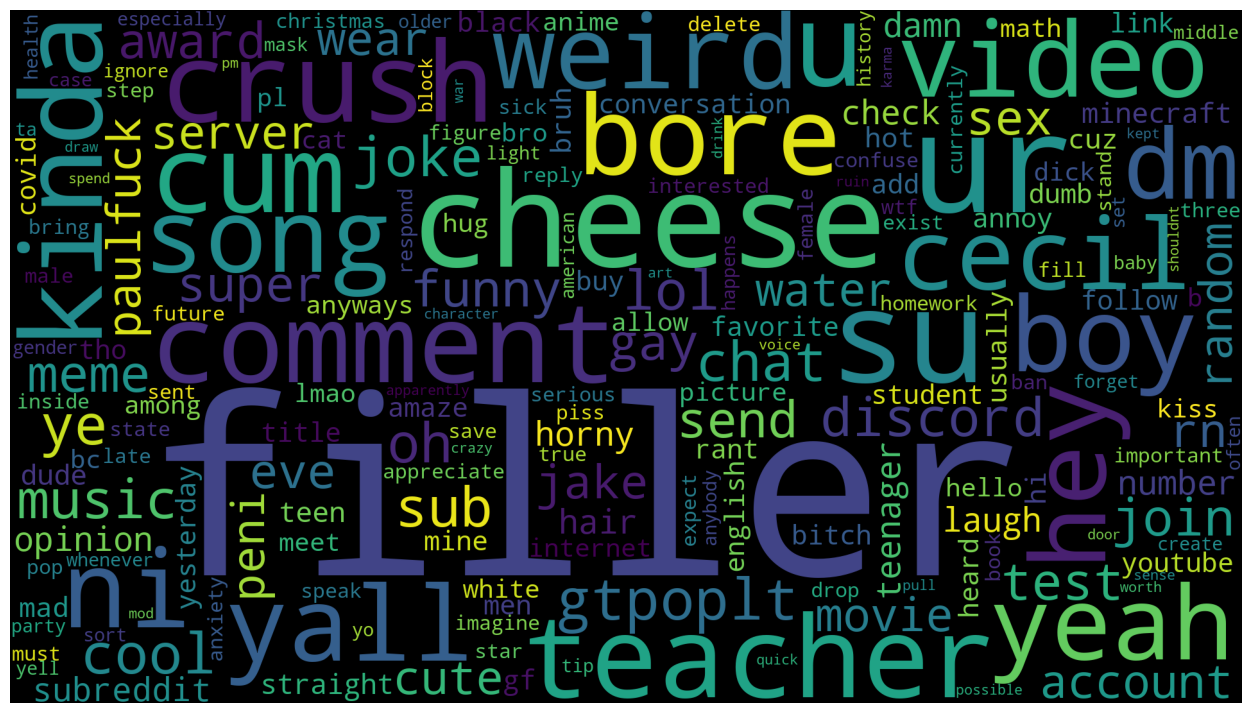

In [11]:
perform_eda()

In [12]:
!mkdir -p  $PLOTS_OUTPUT
!mkdir -p  $MODEL_OUTPUT

The syntax of the command is incorrect.
The syntax of the command is incorrect.


Map:   0%|          | 0/228593 [00:00<?, ? examples/s]

Map:   0%|          | 0/2321 [00:00<?, ? examples/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/300
114296/114296 [==============================] - 11382s 100ms/step - loss: 0.1015 - val_loss: 0.0850 - accuracy: 0.9716
Epoch 2/300
114296/114296 [==============================] - 10805s 95ms/step - loss: 0.0735 - val_loss: 0.1294 - accuracy: 0.9703
Epoch 3/300
114296/114296 [==============================] - 9856s 86ms/step - loss: 0.0646 - val_loss: 0.0921 - accuracy: 0.9681
Epoch 4/300
114296/114296 [==============================] - 10010s 88ms/step - loss: 0.0595 - val_loss: 0.1337 - accuracy: 0.9655
Epoch 5/300
114296/114296 [==============================] - 9798s 86ms/step - loss: 0.0638 - val_loss: 0.0992 - accuracy: 0.9668
Epoch 6/300
114296/114296 [==============================] - 9785s 86ms/step - loss: 0.0613 - val_loss: 0.1066 - accuracy: 0.9638
Epoch 7/300
114296/114296 [==============================] - 9791s 86ms/step - loss: 0.0603 - val_loss: 0.1348 - accuracy: 0.9586
Epoch 8/300
114296/114296 [==============================] - 9983s 87ms/step - loss: 0

Some layers from the model checkpoint at ./assets/output/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./assets/output/model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


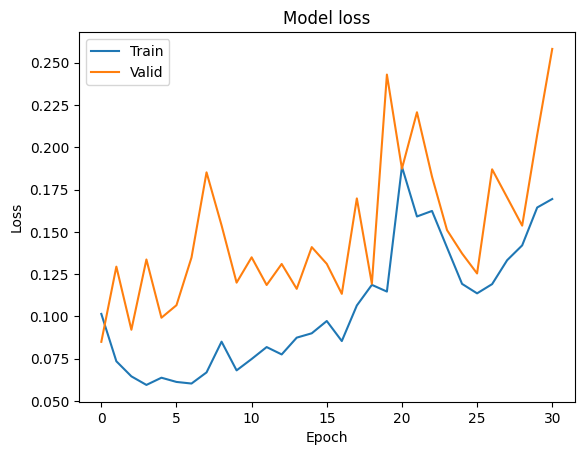

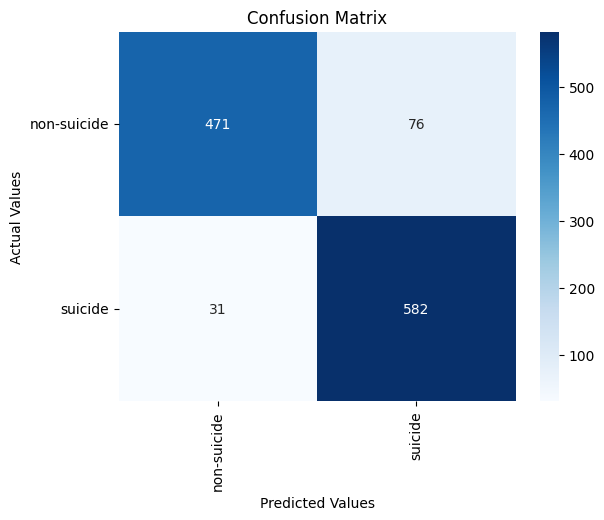

In [13]:
tokenizer = get_tokenizer()

tokenized_dataset, test_dataset = prime_dataset(tokenizer=tokenizer)

model = train_model(tokenizer=tokenizer, tokenized_dataset=tokenized_dataset, test_dataset=test_dataset)

In [14]:
trained_pipeline = get_trained_pipeline()

Some layers from the model checkpoint at ./assets/output/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./assets/output/model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
evaluate_model(test_dataset=test_dataset)

Some layers from the model checkpoint at ./assets/output/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./assets/output/model and are newly initialized: ['dropout_379']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'accuracy': 0.9094827586206896,
 'precision': 0.867579908675799,
 'recall': 0.9693877551020408,
 'f1_score': 0.9156626506024097}

In [16]:
text = 'This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three.'
trained_pipeline(text, truncation=True, max_length=4096)

[{'label': 'non-suicide', 'score': 0.6055302619934082}]

In [17]:
text = 'I am severly depressed'
trained_pipeline(text, truncation=True, max_length=4096)

[{'label': 'suicide', 'score': 0.7709288001060486}]